In [2]:
## Importing necessary Libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Grid Search
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#metrics 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Importing csv file
df=pd.read_csv('C:\\Users\\Shubham Shinde\\Downloads\\data.csv')
df.head()

,x1,x2,y
0,-119.366669,115.000000,1
1,-101.108044,97.777159,1
2,-130.278658,106.767654,1
3,-114.703415,101.195477,1
4,-119.366669,115.000000,1


## Checking Data Information

In [4]:
df.shape

(2227, 3)

Data Contains 2227 rows and 3 columns.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2222 non-null   float64
 1   x2      2224 non-null   float64
 2   y       2227 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 52.3 KB


In [6]:
df.dtypes

x1    float64
x2    float64
y       int64
dtype: object

All Attribute contains numerical data.

In [7]:
df.describe()

,x1,x2,y
count,2222.000000,2.224000e+03,2227.000000
mean,-4.818766,8.947626e+04,0.442299
std,74.939909,2.983323e+06,0.496771
min,-134.369160,-1.348761e+02,0.000000
25%,-71.757030,-8.012983e+01,0.000000
50%,-9.836555,-1.046151e+00,0.000000
75%,59.813962,6.389086e+01,1.000000
max,134.508687,1.000000e+08,1.000000


In [8]:
df['y'].unique()

array([1, 0], dtype=int64)

y attribute contain 2 classes 0 and 1

In [9]:
df['y'].value_counts()

0    1242
1     985
Name: y, dtype: int64

<AxesSubplot:xlabel='y', ylabel='count'>

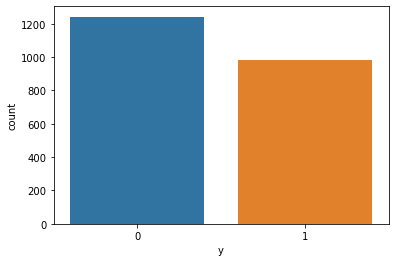

In [10]:
sns.countplot(df['y'])

## Exploratory Data Analysis

<AxesSubplot:xlabel='x1', ylabel='Density'>

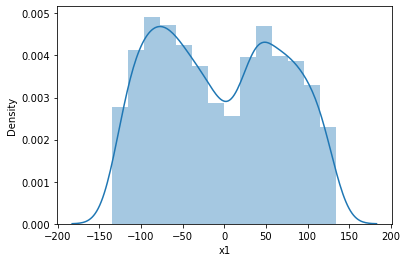

In [11]:
sns.distplot(df['x1'])

<AxesSubplot:xlabel='x2', ylabel='Density'>

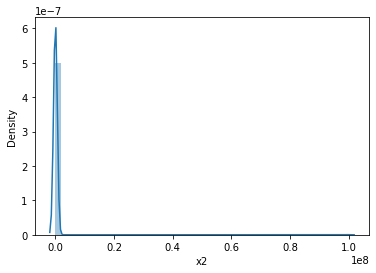

In [12]:
sns.distplot(df['x2'])

In [13]:
## Checking missing values if any
df.isna().sum()

x1    5
x2    3
y     0
dtype: int64

In [14]:
## Finding the mean ,median,mode of x1 column
df['x1'].mean(),df['x1'].median(),df['x1'].mode()[0]

(-4.818766123605403, -9.836555486, -118.36666869999999)

In [15]:
# Finding the mean ,median,mode of x2 column
df['x2'].mean(),df['x2'].median(),df['x2'].mode()[0]

(89476.25894136279, -1.04615092, -113.0)

In [16]:
## Lets Fill the missing values by median to avoid the outliers 
df['x1']=df['x1'].fillna(df['x1'].median())
df['x2']=df['x2'].fillna(df['x2'].median())

In [17]:
df.isna().sum()

x1    0
x2    0
y     0
dtype: int64

Contain no missing values now.

In [18]:
## Checking duplicate values if any
df.duplicated().sum()

16

We found 16 duplicate values.

In [19]:
duplicated_df=df[df.duplicated()]
duplicated_df

,x1,x2,y
4,-119.366669,115.0,1
477,-118.366669,107.0,1
484,-118.366669,107.0,1
490,-118.366669,132.0,1
707,129.633331,-122.0,1
775,-50.366669,46.0,1
981,85.633331,-126.0,1
1356,34.633331,17.0,0
1380,30.633331,9.0,0
1479,-117.366669,-124.0,0


we keep the duplicate values as it is as they are not exactly similar to each other.

<AxesSubplot:>

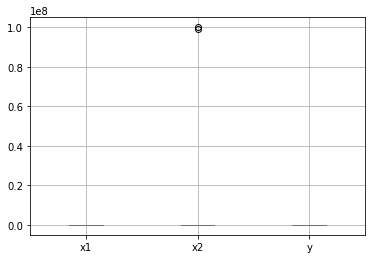

In [20]:
## Checking Outliers by using boxplot
df.boxplot()

In [21]:
## Checking Minimum and maximun value
df['x2'].max(),df['x2'].min()

(99999999.0, -134.8761321)

In [22]:
df['x1'].max(),df['x1'].min()

(134.5086874, -134.3691605)

In [23]:
## Cliping the outliers

def Clipvalues(df,lower,upper):
    for col in df.columns:
        l=df[col].quantile(lower)
        u=df[col].quantile(upper)
        df[col]=df[col].clip(l,u)
    return df       

<AxesSubplot:>

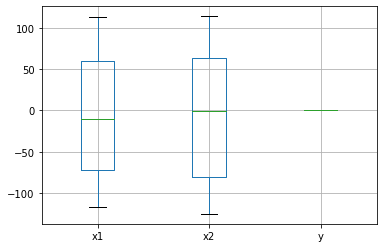

In [24]:
## Clipping  outliers by lower(5%) and upper(95%) quantile values.
df1=df
df1=Clipvalues(df,0.05,0.95)
df1.boxplot()

## Model Selection

In [25]:
#key = model name value = models object
models={"LogisticRegression":LogisticRegression(),
        "DecisionTreeClassifier":DecisionTreeClassifier(),
        "KNeighborsClassifier":KNeighborsClassifier(),
        "SVC_with_linear kernel":SVC(kernel='linear'),
        "SVC_with_rbf kernel":SVC(kernel='rbf')
       }

## Automatic Model Training Function

In [26]:
#model_training function is for training various models on the dataset
#@models -> dictionary 
#@xtrain -> Training Attributes
#@xtest -> Testing Attributes
#@ytrain -> Train class
#ytest-> test class
#scale_flag -> 0(no scaling),1(standard),2(minmax)

def model_training(models,xtrain,xtest,ytrain,ytest,scale_flag):
    acc_result={}
    for name,model in models.items():
        try:
            if (scale_flag==1):
                model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])
            elif(scale_flag==2):
                model_pipeline=Pipeline([('MinMaxScaler',MinMaxScaler()),('model',model)])
            else:
                model_pipeline=Pipeline([('model',model)])
            
            #Model Training and Prediction
            model_fit=model_pipeline.fit(xtrain,ytrain)
            ypred=model_fit.predict(xtest)
            acc=accuracy_score(ytest,ypred)
            print("Accuracy for {} is {}".format(name, acc))
            acc_result[name]=acc
        except:
            print("Something went wrong")
    return acc_result        

In [27]:
## x=> independent variable    y=> dependent variable

x=df.drop(columns='y')
y=df['y']

In [28]:
## Splitting data intro train and test
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)

In [29]:
## Accuracy on no scaled data
model_result=model_training(models,xtrain,xtest,ytrain,ytest,0)

Accuracy for LogisticRegression is 0.7376681614349776
Accuracy for DecisionTreeClassifier is 0.9304932735426009
Accuracy for KNeighborsClassifier is 0.9551569506726457
Accuracy for SVC_with_linear kernel is 0.7331838565022422
Accuracy for SVC_with_rbf kernel is 0.9641255605381166


In [30]:
## Accuracy on Standard Scaled Data
model_result=model_training(models,xtrain,xtest,ytrain,ytest,1)

Accuracy for LogisticRegression is 0.7376681614349776
Accuracy for DecisionTreeClassifier is 0.9304932735426009
Accuracy for KNeighborsClassifier is 0.952914798206278
Accuracy for SVC_with_linear kernel is 0.7331838565022422
Accuracy for SVC_with_rbf kernel is 0.9641255605381166


In [31]:
## Accuracy on MinMax Scaled Data
model_result=model_training(models,xtrain,xtest,ytrain,ytest,2)

Accuracy for LogisticRegression is 0.7376681614349776
Accuracy for DecisionTreeClassifier is 0.9304932735426009
Accuracy for KNeighborsClassifier is 0.952914798206278
Accuracy for SVC_with_linear kernel is 0.7331838565022422
Accuracy for SVC_with_rbf kernel is 0.9641255605381166


The best model among all above models is SVC with rbf kernel having highest accuracy 0.9641255605381166 in all 3 format of data.

## Hypertuning of SVC model

In [33]:
#Model
model=SVC()

## paramenters
kernel=['rbf']
class_weight=['balanced']
gamma=['scale','auto']
degree=[1,2,3,4,5]

## grid
grid=dict(kernel=kernel,class_weight=class_weight,gamma=gamma,degree=degree)

## cv
cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=42)

## GridSearchCV
grid_cv=GridSearchCV(estimator=model,cv=cv,param_grid=grid,scoring='accuracy')

##result
res=grid_cv.fit(xtrain,ytrain)
print('Best Parameters are :',res.best_params_)
print('Best Accuracy is :',res.best_score_)

Best Parameters are : {'class_weight': 'balanced', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy is : 0.9425445084400802


In [34]:
## Retraining model on tuned parameters
model=SVC(class_weight='balanced',degree=1,gamma='scale',kernel='rbf')
model.fit(xtrain,ytrain)

SVC(class_weight='balanced', degree=1)

In [35]:
## Model Prediction
ypred=model.predict(xtest)

Accuracy is : 0.9573991031390134
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       242
           1       0.93      0.98      0.95       204

    accuracy                           0.96       446
   macro avg       0.96      0.96      0.96       446
weighted avg       0.96      0.96      0.96       446



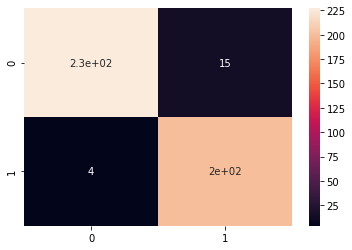

In [36]:
## Evaluation of model
cm=confusion_matrix(ytest,ypred)
sns.heatmap(cm,annot=True)
print("Accuracy is :",accuracy_score(ytest,ypred))
print(classification_report(ytest,ypred))

## HyperTuning on Logistic Regression

In [38]:
#Model
model=LogisticRegression()

## paramenters
penalty=['l1','l2','elasticnet']
class_weight=['balanced']
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

## grid
grid=dict(penalty=penalty,class_weight=class_weight,solver=solver)

## cv
cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=42)

## GridSearchCV
grid_cv=GridSearchCV(estimator=model,cv=cv,param_grid=grid,scoring='accuracy')

##result
res=grid_cv.fit(xtrain,ytrain)
print('Best Parameters are :',res.best_params_)
print('Best Accuracy is :',res.best_score_)

Best Parameters are : {'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy is : 0.5740266893274163


In [39]:
## Retraining model on tuned parameters
model=LogisticRegression(class_weight='balanced',penalty='l2',solver= 'newton-cg')
model.fit(xtrain,ytrain)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [40]:
## Model Prediction
ypred=model.predict(xtest)

Accuracy is : 0.5448430493273543
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       242
           1       0.50      0.54      0.52       204

    accuracy                           0.54       446
   macro avg       0.54      0.54      0.54       446
weighted avg       0.55      0.54      0.55       446



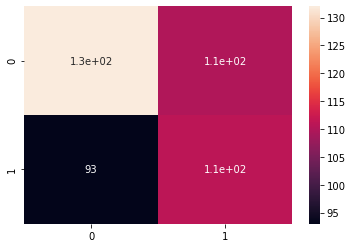

In [41]:
## Evaluation of model
cm=confusion_matrix(ytest,ypred)
sns.heatmap(cm,annot=True)
print("Accuracy is :",accuracy_score(ytest,ypred))
print(classification_report(ytest,ypred))

## HyperTuning of Decision Tree Classifier

In [44]:
#Model
model=DecisionTreeClassifier()

## paramenters
criterion = ["gini", "entropy"]
splitter=['best','random']
max_depth=[5,10,15,20]
max_features=["auto", "sqrt", "log2"]
class_weight=['balanced']


## grid
grid=dict(criterion =criterion ,splitter=splitter,max_depth=max_depth,max_features=max_features,class_weight=class_weight)

## cv
cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=42)

## GridSearchCV
grid_cv=GridSearchCV(estimator=model,cv=cv,param_grid=grid,scoring='accuracy')

##result
res=grid_cv.fit(xtrain,ytrain)
print('Best Parameters are :',res.best_params_)
print('Best Accuracy is :',res.best_score_)

Best Parameters are : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'splitter': 'best'}
Best Accuracy is : 0.9292601684868704


In [46]:
## Retraining model on tuned parameters
model=DecisionTreeClassifier(class_weight= 'balanced', criterion= 'gini', max_depth= 20, max_features= 'sqrt', splitter= 'best')
model.fit(xtrain,ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt')

In [47]:
## Model Prediction
ypred=model.predict(xtest)

Accuracy is : 0.9304932735426009
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       242
           1       0.94      0.91      0.92       204

    accuracy                           0.93       446
   macro avg       0.93      0.93      0.93       446
weighted avg       0.93      0.93      0.93       446



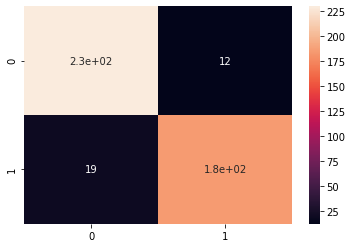

In [48]:
## Evaluation of model
cm=confusion_matrix(ytest,ypred)
sns.heatmap(cm,annot=True)
print("Accuracy is :",accuracy_score(ytest,ypred))
print(classification_report(ytest,ypred))

## Conclusion 

### 1.SVC Model with rbf kernel
Without hyperparameter tuning accuracy of model is 0.9641255605381166

After Hyperparameter Tuning accuracy is
          
                Accuracy is : 0.9573991031390134
                precision   recall  f1-score   support

           0       0.98      0.94      0.96       242
           1       0.93      0.98      0.95       204
    

## 2. Logistic Regression

Without hyperparameter tuning accuracy of model is 0.7376681614349776

After Hyperparameter Tuning accuracy is
             
              Accuracy is : 0.5448430493273543
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       242
           1       0.50      0.54      0.52       204


## 3.Decision Tree Classifier

Without hyperparameter tuning accuracy of model is 0.9304932735426009

After Hyperparameter Tuning accuracy is
        
              Accuracy is : 0.9304932735426009
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       242
           1       0.94      0.91      0.92       204


## 4. KNN Classifier

Without hyperparameter tuning accuracy of model is 0.952914798206278


# Final Conclusion

By Comparing all above model we can conclude that the best model is SVM with kernel rbf having accuracy 0.9641255605381166